In [1]:
import numpy as np
import functools as ft
import math, cmath
from numba import njit, prange, types, jit
from numba.extending import overload
from scipy.special import eval_jacobi
from scipy import integrate

In [85]:
d = 4
m = complex(0, 2)
print("Using m^2 =", (m * m).real)
Dpl = d/2 + 0.5 * cmath.sqrt(d * d + 4.0 * (m * m).real)
Dmin = d/2 - 0.5 * cmath.sqrt(d * d + 4.0 * (m * m).real)
NPOW = 15
J_0 = 1.
LMAX = 6
DX = np.pi/(2*((2**NPOW) + 1))
XGRID = np.linspace(0, np.pi/2, (2 ** NPOW) + 1, dtype=np.double) # romb method requires 2**k + 1 gridpoints

Using m^2 = -4.0


In [86]:
# Test input values
m_BF = - d * d / 4
if (m * m).real < m_BF:
    print("ERROR: Mass-squared must be greater than the " +
         "Breitenlohmer-Freedman bound:", m_BF)
if Dpl.imag == 0: 
    Dpl = Dpl.real
else:
    print("ERROR: Must have real Delta_plus value")                          
if Dmin.imag == 0: 
    Dmin = Dmin.real
else:
    print("ERROR: Must have real Delta_minus value")

In [87]:
# See recursion relationships between Jacobi polynomials 
@njit
def my_jacobi(n, a, b, x):
    if n < 0:
        return 0.
    elif n == 0:
        return J_0
    elif n == 1:
        return (a + 1) + (a + b + 2) * (x - 1) / 2
    else:
        jac_factor = 2 * n + a + b - 1
        outval = jac_factor * ((jac_factor + 1) * (jac_factor - 1) * x + (a * a)\
                               - (b * b)) * my_jacobi(n - 1, a, b, x)
        outval -= 2 * (n + a - 1) * (n + b - 1) * (jac_factor + 1) * my_jacobi(n - 2, a, b, x)
        return outval / (2 * n * (n + a + b) * (jac_factor - 1))
                    
my_jacobi(4, d/2 - 1, Dpl - d/2, np.cos(2 * np.pi/3))

-0.1328124999999994

In [88]:
@njit
def mu(x):
    return (np.tan(x)) ** (d-1)

# Evaluate the derivatives analytically
@njit
def nu(x):
    return (np.cos(x)) ** 2 * (np.tan(x)) ** (2 - d)

@njit
def nup(x):
    return (1 - d + np.cos(2.*x)) * (np.tan(x)) ** (1 - d) 

@njit
def omega(i):
    return Dpl + 2 * i
mu(0)
nu(np.pi)
nup(np.pi/4)
omega(0)

2.0

In [89]:
@njit
def K(i):
    return 2. * np.sqrt((i + Dpl / 2) * math.gamma(i + 1) * math.gamma(Dpl + i) / (math.gamma(i + d/2) * math.gamma(
        i + Dpl + 1 - d/2)))

K(1)

2.8284271247461903

In [90]:
@njit
def e(x, j):
    return K(j) * (np.cos(x)) ** Dpl * my_jacobi(j, d/2 - 1, Dpl - d/2, np.cos(2 * x))

e(np.pi/4, 4)

0.838525491562421

In [91]:
@njit
def ep(x, j):
    return -1. * K(j) * np.tan(x) * (np.cos(x)) ** Dpl * (2 * (Dpl + j) * np.cos(x) ** 2 * my_jacobi(j - 1, 
            d/2, Dpl + 1 - d/2, np.cos(2 * x)) + Dpl * my_jacobi(j, d/2 - 1, Dpl - d/2, np.cos(2 * x)))

ep(np.pi/3, 4)

-4.205817852522124

In [92]:
# Remove the need to include nu(x) in the integrals by using 
# the identity mu(x)nu(x) = sin(x)cos(x)
@njit
def V_integrand(x, i, j, k, l):
    return mu(x) * np.sin(x) * np.cos(x) * e(x, i) * e(x, j) * ep(x, k) * e(x, l) * (1 / np.cos(x)) ** 2

@njit
def X_integrand(x, i, j, k, l):
    return mu(x) * np.sin(x) * np.cos(x) * ep(x, i) * e(x, j) * e(x, k) * e(x, l)

@njit
def Y_integrand(x, i, j, k, l):
    return mu(x) * np.sin(x) * np.cos(x) * ep(x, i) * ep(x, j) * e(x, k) * ep(x, l)

@njit
def B_integrand(x, y, i, j, l):
    return np.sin(x) * np.cos(x) * ep(x, i) * ep(x, j) * mu(y) * e(y, l) * e(y, l)
    

X_integrand(np.pi/4,0,0,0,0)
Y_integrand(np.pi/4,0,0,0,0)
V_integrand(np.pi/3,1,2,3,4)
B_integrand(np.pi/4,np.pi/4,0,0,0)

2.0

In [9]:
# Time iterations of the function
%timeit V_integrand(np.pi/4,1,2,3,4)

1.54 µs ± 144 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [10]:
# Note: these functions cannot be executed using Numba because of calls to scipy.integrate
# After testing cumulative trapezoid and simpsons methods, romb does the job just as well
def X_integral(i,j,k,l):
    return integrate.romb([X_integrand(xval, i, j, k, l) for xval in XGRID], dx=np.pi/(2*len(XGRID)))

def Y_integral(i,j,k,l):
    return integrate.romb([Y_integrand(xval, i, j, k , l) for xval in XGRID], dx=np.pi/(2*len(XGRID)))

def V_integral(i,j,k,l):
    return integrate.romb([V_integrand(xval, i, j, k , l) for xval in XGRID], dx=np.pi/(2*len(XGRID)))

X_integral(0,0,0,0)
Y_integral(0,0,0,0)
V_integral(1,2,3,4)

-16.814303173922

In [12]:
integrate.quad(V_integrand, 0, np.pi/2, args=(1,2,3,4))[0]

-16.81481630573272

In [93]:
# Write an integral approximator that uses parallelism and a simple mid-point method. 
# Should be used with numba and parallel=True to maximize performance

@njit(parallel=True)
def X(i,j,k,l):
    # Approximate the integral by adding together area elements over the integration domain.
    # Use an average of the function f_av = (f(x) + f(x + dx)) / 2 and multiply by the width of the interval.
    result = np.zeros((2**NPOW,), dtype=np.double)
    for val in prange(2**NPOW):
        result[val] = (X_integrand(XGRID[val],i,j,k,l) + X_integrand(XGRID[val+1],i,j,k,l)) / 2 * DX
    return np.sum(result)

@njit(parallel=True)
def Y(i,j,k,l):
    # Approximate the integral by adding together area elements over the integration domain.
    # Use an average of the function f_av = (f(x) + f(x + dx)) / 2 and multiply by the width of the interval.
    result = np.zeros((2**NPOW,), dtype=np.double)
    for val in prange(2**NPOW):
        result[val] = (Y_integrand(XGRID[val],i,j,k,l) + Y_integrand(XGRID[val+1],i,j,k,l)) / 2 * DX
    return np.sum(result)

@njit(parallel=True)
def V(i,j,k,l):
    # Approximate the integral by adding together area elements over the integration domain.
    # Use an average of the function f_av = (f(x) + f(x + dx)) / 2 and multiply by the width of the interval.
    result = np.zeros((2**NPOW,), dtype=np.double)
    for val in prange(2**NPOW):
        result[val] = (V_integrand(XGRID[val],i,j,k,l) + V_integrand(XGRID[val+1],i,j,k,l)) / 2 * DX
    return np.sum(result)

# Forgoing @njit for ease of use of double quad integration
def B(i,j,l):
    # Note that y MUST preceed x
    def integrand(y, x, i, j, l):
        return np.sin(x) * np.cos(x) * ep(x, i) * ep(x, j) * mu(y) * e(y, l) * e(y, l)
    # Use built-in double integrator with dynamic bounds
    return integrate.dblquad(integrand, 0, np.pi/2, lambda y: 0, lambda y: y, args=(i, j, l))[0]

def P(i,j,l):
    # Note that y MUST preceed x
    def integrand(y, x, i, j, l):
        return np.sin(x) * np.cos(x) * e(x, i) * e(x, j) * mu(y) * e(y, l) * e(y, l)
    # Use built-in double integrator with dynamic bounds
    return integrate.dblquad(integrand, 0, np.pi/2, lambda y: 0, lambda y: y, args=(i, j, l))[0]

def Q(i,j,l):
    # Note that y MUST preceed x
    def integrand(y, x, i, j, l):
        return np.sin(x) * np.cos(x) * e(x, i) * e(x, j) * (1/ np.cos(x)) ** 2 * mu(y) * e(y, l) * e(y, l)
    # Use built-in double integrator with dynamic bounds
    return integrate.dblquad(integrand, 0, np.pi/2, lambda y: 0, lambda y: y, args=(i, j, l))[0]

def M(i,j,l):
    # Note that y MUST preceed x
    def integrand(y, x, i, j, l):
        return mu(x) * nup(x) * ep(x, i) * e(x, j) * mu(y) * e(y, l) * e(y,l)
    # Use built-in double integrator with dynamic bounds
    return integrate.dblquad(integrand, 0, np.pi/2, lambda y: 0, lambda y: y, args=(i, j, l))[0]

# Use numba overloading to pass python functions to @njit functions
"""
@overload(B)
def B_overload(i,j,l):
    result = np.double(B(i,j,l))    
    def spitout():
        return result
    return spitout()

@overload(P)
def P_overload(i,j,l):
    result = np.double(P(i,j,l))
    def spitout():
        return result
    return spitout()

@overload(Q)
def Q_overload(i,j,l):
    result = np.double(Q(i,j,l))
    def spitout():
        return result
    return spitout()

@overload(M)
def M_overload(i,j,l):
    result = np.double(M(i,j,l))
    def spitout():
        return result
    return spitout()
"""

X(0,0,0,0)
Y(0,0,0,0)
V(1,2,3,4)
print("B(%d,%d,%d) = %e" % (1,1,2, B(1,1,2)))
print("P(%d,%d,%d) = %e" % (1,2,3, P(1,2,3)))
print("Q(%d,%d,%d) = %e" % (1,2,1, Q(1,2,1)))
print("M(%d,%d,%d) = %e" % (3,2,1, M(3,2,1)))

B(1,1,2) = 5.325253e+00
P(1,2,3) = 4.299454e-01
Q(1,2,1) = 1.749636e-01
M(3,2,1) = 1.437627e+01


In [13]:
# print("Timing of approximation function:")
# %timeit X(1,2,3,4)
# print("Timing of romberg integration:")
# %timeit X_integral(1,2,3,4)

In [94]:
# Use integration by parts to write H_ijkl in terms of other,
# more well-behaved, integrals

@njit
def H(i,j,k,l):
    return omega(i) ** 2 * X(k,i,j,l) + omega(k) ** 2 * X(i,j,k,l) \
            - Y(i,j,l,k) - Y(l,k,j,i) - (m * m).real * (V(i,j,k,l) + V(k,j,i,l))

# Combinations of integrals
@njit
def Zpl(i,j,k,l):
    return omega(i) * omega(j) * (X(k,l,i,j) - X(l,k,i,j)) \
            + (Y(i,j,l,k) - Y(i,j,k,l))
@njit
def Zmin(i,j,k,l):
    return omega(i) * omega(j) * (X(k,l,i,j) - X(l,k,i,j)) \
            - (Y(i,j,l,k) - Y(i,j,k,l))

H(0,0,0,0)
print("M(%d,%d,%d) = %e" % (3,2,1, M(3,2,1)))
Zpl(0,0,0,0)
Zmin(0,0,0,0)

M(3,2,1) = 1.437627e+01


0.0

In [56]:
# Source term for +++ resonance channel

@njit
def Omega(i,j,k,l):
    return (-1./12) * H(i,j,k,l) * omega(j) * (omega(i) + omega(k) +        
        2 * omega(j)) / ((omega(i) + omega(j)) * (omega(j) + omega(k))) \
        - (1./12) * H(i,k,j,l) * omega(k) * (omega(i) + omega(j) + 
        2 * omega(k)) / ((omega(i) + omega(k)) * (omega(j) + omega(k))) \
        - (1./12) * H(j,i,k,l) * omega(i) * (omega(j) + omega(k) + 
        2 * omega(i)) / ((omega(i) + omega(j)) * (omega(i) + omega(k))) \
        - (1./12) * m ** 2 * V(i,j,k,l) * (1 + omega(j) / (omega(j) + omega(k))
        + omega(i) / (omega(i) + omega(k))) \
        - (1./12) * m ** 2 * V(j,k,i,l) * (1 + omega(j) / (omega(i) + omega(j))
        + omega(k) / (omega(i) + omega(k))) \
        - (1./12) * m ** 2 * V(k,i,j,l) * (1 + omega(i) / (omega(i) + omega(j))
        + omega(k) / (omega(j) + omega(k))) \
        + (1./6) * X(j,k,i,l) * omega(i) * omega(k) * (1 + omega(i) / (omega(j)
        + omega(k)) + omega(k) / (omega(i) + omega(j))) \
        + (1./6) * X(k,i,j,l) * omega(i) * omega(j) * (1 + omega(i) / (omega(j) 
        + omega(k)) + omega(j) / (omega(i) + omega(k))) \
        + (1./6) * X(i,j,k,l) * omega(j) * omega(k) * (1 + omega(j) / (omega(i) 
        + omega(k)) + omega(k) / (omega(i) + omega(j))) \
        - (1./12) * Zmin(i,j,k,l) * omega(k) / (omega(i) + omega(j)) \
        - (1./12) * Zmin(i,k,j,l) * omega(j) / (omega(i) + omega(k)) \
        - (1./12) * Zmin(j,k,i,l) * omega(i) / (omega(j) + omega(k))

Omega(0,0,0,0)

(-2.6665852889417847+0j)

In [13]:
# Source term for +-- resonance channel

@njit
def Gamma(i,j,k,l):
    return (1./4) * H(i,j,k,l) * omega(j) * (omega(k) - omega(i) + \
            2 * omega(j)) / ((omega(i) - omega(j)) * (omega(j) + omega(k))) \
            + (1./4) * H(j,k,i,l) * omega(k) * (omega(j) - omega(i) + \
            2 * omega(k)) / ((omega(i) - omega(k)) * (omega(j) + omega(k))) \
            + (1./4) * H(k,i,j,l) * omega(i) * (omega(j) + omega(k) - \
            2 * omega(i)) / ((omega(i) - omega(j)) * (omega(i) - omega(k))) \
            - (1./2) * omega(j) * omega(k) * X(i,j,k,l) * (omega(k) / (omega(i) - omega(j)) + \
            omega(j) / (omega(i) - omega(k)) - 1) \
            + (1./2) * omega(i) * omega(k) * X(j,k,i,l) * (omega(k) / (omega(i) - omega(j)) + \
            omega(i) / (omega(j) + omega(k)) - 1) \
            + (1./2) * omega(i) * omega(j) * X(k,i,j,l) * (omega(j) / (omega(i) - omega(k)) + \
            omega(i) / (omega(j) + omega(k)) - 1) \
            + (1./4) * m ** 2 * V(j,k,i,l) * (omega(j) / (omega(i) - omega(j)) + \
            omega(k) / (omega(i) - omega(k)) - 1) \
            - (1./4) * m ** 2 * V(k,i,j,l) * (omega(i) / (omega(i) - omega(j)) + \
            omega(k) / (omega(j) + omega(k)) + 1) \
            - (1./4) * m ** 2 * V(i,j,k,l) * (omega(i) / (omega(i) - omega(k)) + \
            omega(j) / (omega(j) + omega(k)) + 1) \
            + (1./4) * Zmin(k,j,i,l) * omega(i) / (omega(j) + omega(k)) \
            - (1./4) * Zpl(i,j,k,l) * omega(k) / (omega(i) - omega(j)) \
            - (1./4) * Zpl(j,k,i,l) * omega(j) / (omega(i) - omega(k))

Gamma(Dpl+3,1,1,1)

7.299740562863054

In [95]:
# Source term for S in non-vanishing channel

@jit
def S_ppm(i,j,k,l):
    return -0.25 * H(k,i,j,l) * omega(i) * (omega(j) - omega(k) + 2. * omega(i)) / \
            ((omega(i) - omega(k)) * (omega(i) + omega(j))) - \
            0.25 * H(i,j,k,l) * omega(j) * (omega(i) - omega(k) + 2. * omega(j)) / \
            ((omega(j) - omega(k)) * (omega(i) + omega(j))) - \
            0.25 * H(j,k,i,l) * omega(k) * (omega(i) + omega(j) - 2. * omega(k)) / \
            ((omega(i) - omega(k)) * (omega(j) - omega(k))) - \
            0.5 * omega(j) * omega(k) * X(i,j,k,l) * \
            (omega(j) / (omega(i) - omega(k)) - omega(k) / (omega(i) + omega(j)) + 1) - \
            0.5 * omega(i) * omega(k) * X(j,k,i,l) * \
            (omega(i) / (omega(j) - omega(k)) - omega(k) / (omega(i) + omega(j)) + 1) + \
            0.5 * omega(i) * omega(j) * X(k,i,j,l) * \
            (omega(i) / (omega(j) - omega(k)) + omega(j) / (omega(i) - omega(k)) + 1) - \
            0.25 * (m * m).real * V(i,j,k,l) * (omega(i) / (omega(i) - omega(k)) + \
            omega(j) / (omega(j) - omega(k)) + 1) + \
            0.25 * (m * m).real * V(j,k,i,l) * (omega(k) / (omega(i) - omega(k)) - \
            omega(j) / (omega(i) + omega(j)) - 1) + \
            0.25 * (m * m).real * V(i,j,k,l) * (omega(k) / (omega(j) - omega(k)) - \
            omega(i) / (omega(i) + omega(j)) - 1) + \
            0.25 * Zmin(i,j,k,l) * omega(k) / (omega(i) + omega(j)) + \
            0.25 * Zpl(i,k,j,l) * omega(j) / (omega(i) - omega(k)) + \
            0.25 * Zpl(j,k,i,l) * omega(i) / (omega(j) - omega(k))

# Functions containing the results from integrate.dblquad are not cooperating with @njit compilation
# After iteration timings, no appreciable speedup without @njit call

def R_ppm(i,l):
    return omega(i) ** 2 * (Y(i,l,l,i) - Y(i,l,i,l) + omega(l) ** 2 * (X(i,l,i,l) - X(l,i,l,i))) / \
            (omega(l) ** 2 - omega(i) ** 2) + \
            omega(i) ** 2 * (H(l,i,i,l) + (m * m).real * V(i,i,l,l) - 2 * omega(i) ** 2 * X(l,i,i,l)) / \
            (omega(l) ** 2 - omega(i) ** 2) - \
            omega(l) ** 2 * (H(i,l,i,l) + (m * m).real * V(l,i,i,l) - 2 * omega(i) ** 2 * X(i,l,i,l)) / \
            (omega(l) ** 2 - omega(i) ** 2) - \
            0.25 * (m * m).real * (V(i,l,i,l) + V(i,i,l,l)) + \
            omega(i) ** 2 * omega(l) ** 2 * (P(i,i,l) - 2. * P(l,l,i)) - \
            omega(i) * omega(l) * X(i,l,i,l) - 1.5 * (m * m).real * V(l,i,i,l) - \
            0.5 * H(i,i,l,l) + omega(l) ** 2 * B(i,i,l) - omega(i) ** 2 * M(l,l,i) - \
            omega(i) ** 2 * (m * m).real * Q(l,l,i)

def T_ppm(l):
    return 0.5 * omega(l) ** 2 * (X(l,l,l,l) + 4. * B(l,l,l) - 2. * M(l,l,l) - \
            2. * (m * m).real * Q(l,l,l)) - 0.75 * (H(l,l,l,l) + 3. * (m * m).real * V(l,l,l,l))

print("S_ppm(%d,%d,%d,%d) =" % (1,1,2,0), S_ppm(1,1,2,0))
print("R_ppm(%d,%d) =" % (1,0), R_ppm(1,0))
print("T_ppm(%d) =" % (0), T_ppm(0))

S_ppm(1,1,2,0) = 19.39837705328467
R_ppm(1,0) = -6.628996917818842
T_ppm(0) = -5.066463222354473


In [ ]:
def ppm_resonances(Lmax):
    results = np.zeros((Lmax + 1,), dtype=np.double)
    for l in range(Lmax + 1):
        outval = T_ppm(l)
        for i in range(Lmax + 1):
            if i != l:
                outval += R_ppm(i,l)
            else:
                pass
            for j in prange(Lmax + 1):
                if (i + j - l) >= 0:
                    outval += S_ppm(i, j, i + j - l, l)
                else:
                    pass
        results[l] = outval
    return resutls

In [70]:
# Run values of S, R, T for different choices of mass
def norm_RT(Lmax):
    tee = np.zeros((Lmax + 1,), dtype=np.double)
    are = np.zeros_like(tee)
    for l in range(Lmax + 1):
        tee[l] = T_ppm(l)
        for i in range(Lmax + 1):
            if i == l:
                pass
            else:
                are[l] += R_ppm(i,l)

    print("Finished calculating R and T. Writing results to file.")
    
    with open("./data/NormR.dat", "a") as f:
        f.write("%1.14e " % (m * m).real)
        for val in are:
            f.write("%1.14e " % val)
        f.write("\n")
        print("Finished writing to", f.name)
    with open("./data/NormT.dat", "a") as f:
        f.write("%1.14e " % (m * m).real)
        for val in tee:
            f.write("%1.14e " % val)
        f.write("\n")
        print("Finished writing to", f.name)
        

In [71]:
norm_RT(10)

Finished calculating R and T. Writing results to file.
Finished writing to ./data/NormR.dat
Finished writing to ./data/NormT.dat


In [96]:
@njit
def norm_S(Lmax):
    ess = np.zeros((Lmax + 1,), dtype=np.double)
    for l in range(Lmax + 1):
        prog = (l + 1.) / (Lmax + 1) * 100
        print("Progress:", prog)
        for i in range(Lmax + 1):
            for j in range(Lmax + 1):
                if i + j - l >= 0:
                    if i == l or j == l:
                        pass
                    else:
                        ess[l] += S_ppm(i, j, i + j - l, l)
                else:
                    pass
    return ess
norm_S(0)
S_result = norm_S(10)
print("Finished calculating S. Writing results to file.")
with open("./data/NormS.dat", "a") as f:
    f.write("%1.14e " % (m * m).real)
    for val in S_result:
        f.write("%1.14e " % val)
    f.write("\n")
    print("Finished writing to", f.name)

Progress: 100.0
Progress: 9.090909090909092
Progress: 18.181818181818183
Progress: 27.27272727272727
Progress: 36.36363636363637
Progress: 45.45454545454545
Progress: 54.54545454545454
Progress: 63.63636363636363
Progress: 72.72727272727273
Progress: 81.81818181818183
Progress: 90.9090909090909
Progress: 100.0
Finished calculating S. Writing results to file.
Finished writing to ./data/NormS.dat


dict_keys([0.0])


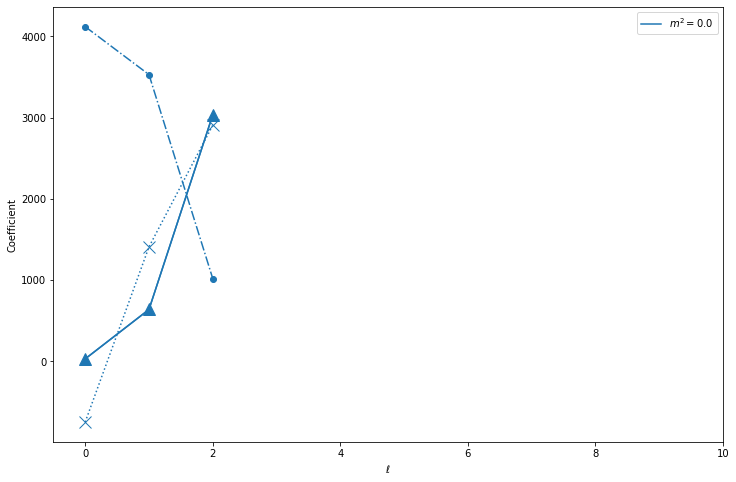

In [43]:
import matplotlib.pyplot as plt

# Import data for normalizable coefficients with different masses
S, R, T = {}, {}, {}
diclist = [R, T, S]
flist = ["./data/Norm" + f + ".dat" for f in ["R", "T", "S"]]
for i in range(len(flist)):
    temp = np.genfromtxt(flist[i], dtype=np.double)
    diclist[i][temp[0]] = temp[1:]
        
# Plot each of the coeffecients for each of the masses
plt.figure(figsize=(12,8))
markerlist = ["^", "x", "."]
linelist = ["-", ":", "-."]
colourlist = ["C" + str(x) for x in range(10)]
ii = 0
for key in sorted(T.keys()):
    xrange = np.arange(len(T.get(key)))
    plt.plot(xrange, T.get(key)[:], marker=markerlist[0], markerfacecolor=colourlist[ii], 
             markeredgecolor=colourlist[ii], markersize=12, linestyle=linelist[0], 
             color=colourlist[ii])
    plt.plot(xrange, T.get(key)[:], color=colourlist[ii], label = r'$m^2 =$' + str(key))
    plt.plot(xrange, R.get(key)[:], marker=markerlist[1], markerfacecolor=colourlist[ii],
            markeredgecolor=colourlist[ii], markersize=12, linestyle=linelist[1], color=colourlist[ii])
    plt.plot(xrange, S.get(key)[:], marker=markerlist[2], markerfacecolor=colourlist[ii],
            markeredgecolor=colourlist[ii], markersize=12, linestyle=linelist[2], color=colourlist[ii])
    ii += 1
    
plt.xlabel(r'$\ell$')
plt.ylabel(r'$S_{ij(i+j-\ell)\ell}$, $R_{i\ell}$, $T_\ell$')
plt.legend()
plt.xlim(-0.5, 10)
plt.hlines(0, -0.5, 10, colors='black', linestyle='dotted', alpha=0.5)

plt.show()             
    

In [14]:
@njit(parallel=True)
def ppp_resonances(Lmax):
    results = np.zeros((Lmax,), dtype=np.double)
    for l in prange(Lmax):
        outval = 0.
        for i in prange(Lmax):
            for j in prange(Lmax):
                if (l - i - j - Dpl >= 0):
                    outval += Omega(i, j, l - i - j - Dpl, l)
                else:
                    pass
        results[l] = outval
    return results
    
ppp_resonances(4)

array([0., 0., 0., 0.])

In [27]:
# This loop is for checking values against those calculated by more general
# basis functions in DrivenTTF_NNResonances

for l in range(6):
    for i in range(6):
        for j in range(6):
            if (l - i - j - Dpl >= 0):
                print("O(%d,%d,%d,%d) = %e" % (i,j,l-i-j-Dpl,l,Omega(i, j, l - i - j - Dpl, l)))
            else:
                pass

O(0,0,0,4) = -5.773160e-14
O(0,0,1,5) = -2.566836e-13
O(0,1,0,5) = -2.571277e-13
O(1,0,0,5) = -2.557954e-13


In [20]:
# ppp_resonances.parallel_diagnostics(level=3)
resonance = ppp_resonances(8)
print(resonance)

[0. 0. 0. 0. 0. 0. 0. 0.]


In [21]:
# Test the required grid size for deviations by comparing values of X(1,2,3,4) directly and 
# the errors between the various integration methods
TEST = False
if (TEST):
    print('-'*15)
    print('-'*15)
    for test_NPOW in range(16):
        test_XGRID = np.linspace(0, np.pi/2, (2**test_NPOW) + 1, dtype=np.double)
        test_DX = np.pi / (2 * ((2 ** test_NPOW) + 1))
    
        exact = integrate.quad(X_integrand, 0, np.pi/2, args=(1,2,3,4))[0]
    
        first_approx = integrate.romb([X_integrand(xval, 1, 2, 3, 4) for xval in test_XGRID], 
                                      dx=np.pi/(2*len(test_XGRID)))
    
        temp_approx = np.zeros((2**test_NPOW,), dtype=np.double)
        for val in prange(2**test_NPOW):
            temp_approx[val] = (0.5 * X_integrand(test_XGRID[val],1,2,3,4) +\
                                0.5 * X_integrand(test_XGRID[val+1],1,2,3,4)) * test_DX
        second_approx = np.sum(temp_approx)
    
        print("NPOW =", test_NPOW)
        print("Number of grid points =", (2**test_NPOW) + 1)
        print("Value from integrate.quad:", exact)
        print("Value from romb method:", first_approx)
        print("Romberg error: %e" % abs((exact - first_approx)/exact))
        print("Value from Newton-Cotes method:", second_approx)
        print("Newton-Cotes error: %e" % abs((exact - second_approx)/exact))
        print('-'*15)

    print('-'*15)
    
else:
    pass

In [22]:
@njit(parallel=True)
def pmm_resonances(Lmax):
    results = np.zeros((Lmax,), dtype=np.double)
    for l in prange(Lmax):
        outval = 0.
        for j in prange(Lmax):
            for k in prange(Lmax):
                outval += Gamma(Dpl + j + k + l, j, k, l)
        results[l] = outval
    return results
    
pmm_resonances(0)

array([], dtype=float64)

In [23]:
resonance = pmm_resonances(3)
print(resonance)

[0. 0. 0.]
